In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold



In [3]:
df_X = pd.read_csv('extract_train_Jul08.csv')
df_y = pd.read_csv('extract_label_Jul08.csv')

In [4]:
df_X = df_X[df_X.columns[1:]]

In [5]:
scaler = StandardScaler()
scaler.fit(df_X)
X = pd.DataFrame(scaler.transform(df_X), columns=df_X.columns)
y = df_y['target']

In [20]:
X.head()

,index,mean,std,skew,FFT_mean_real,FFT_mean_imag,FFT_std_real,FFT_std_max,Roll_std_p05,Roll_std_p30,Roll_std_p60,Roll_std_absDiff,Roll_mean_p05,Roll_mean_absDiff,MFCC_mean02,MFCC_mean16
0,-1.731638,1.424262,-0.170139,-0.313682,1.199478,-0.816780,-0.104855,1.402387,0.138270,0.149755,0.077948,-0.125642,1.053724,-0.487263,-0.292342,0.996658
1,-1.730812,0.805767,0.004826,0.554010,0.078915,0.906173,-0.008441,0.794655,0.141994,0.146040,0.116614,-0.015114,0.697829,-0.137699,-0.409188,1.275636
2,-1.729986,1.511287,0.049349,0.191611,0.078915,0.245314,0.043961,1.487897,0.856458,0.642424,0.477151,0.121665,0.989016,1.078782,-0.408713,1.160981
3,-1.729161,1.495064,0.044046,1.321450,0.078915,-0.509953,0.044960,1.471957,0.375601,0.226170,0.212785,-0.205781,1.053724,-0.095752,-0.156636,0.581138
4,-1.728335,1.520375,0.088596,-0.128283,1.199478,-0.061513,0.078816,1.496827,0.319461,0.227556,0.144474,0.031985,1.215494,0.155934,0.040278,0.387829


In [6]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [7]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

In [24]:
def nn(X_train, y_train, X_val, y_val, X_test):
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='relu'))
   # model.add(Dense(1), W_regularizer=l2(0.01))
#     model.add(activation('softmax'))
    model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
   
    model.fit(X_train.to_numpy(), y_train.to_numpy())

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return y_pred_val.flatten(), y_pred_test

In [9]:
def svm_regression(X_train, y_train, X_val, y_val, X_test):
    model = SVR(kernel='linear')
    selector = RFE(model, 3, step=1)
    selector = selector.fit(X_train.to_numpy(), y_train.to_numpy())
    model.fit(X_train.to_numpy(), y_train.to_numpy())
    
    y_pred_val = np.where(model.predict(X_val)<0,-1*model.predict(X_val),model.predict(X_val))
    y_pred_test = np.where(model.predict(X_test)<0,1*model.predict(X_test),model.predict(X_test))
    
    return y_pred_val.flatten(), y_pred_test, pd.Series(abs(model.coef_[0]), index=X_val.columns).to_numpy()


In [18]:
def svm_dimreduct(X_train, y_train, X_val, y_val, X_test):
    estimator = SVR(kernel='linear')
    selector = RFE(estimator, 3, step=1)
    selector = selector.fit(X_train.to_numpy(), y_train.to_numpy())
    
    
    cols = X_train.columns
    new_cols = []
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            new_cols.append(cols[i])
            
    new_X_train = X_train[new_cols]
    new_X_val = X_val[new_cols]
    new_X_test = X_test[new_cols] 
    
    model = SVR(kernel='rbf')
    model.fit(new_X_train.to_numpy(), y_train.to_numpy())
    
    y_pred_val = model.predict(new_X_val)
    y_pred_test = model.predict(new_X_test)
    
    return y_pred_val.flatten(), y_pred_test

In [11]:
n_fold = 5
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)

In [12]:
def K_fold_evaluation(X, y, X_test, func, classifier):
    y_pred_test_average, y_pred_train, scores = np.zeros(len(X_test)),np.zeros(len(y)), []
    feature_analysis = pd.DataFrame()
    
    print('%s classifier' %classifier)
    for ii, (train_idxes, val_indxes) in enumerate(kfold.split(X)):
        
        # Prepare the data
        X_train, X_val = X.iloc[train_idxes], X.iloc[val_indxes]
        y_train, y_val = y.iloc[train_idxes], y.iloc[val_indxes]
        
        # Fit the model and append score
        y_pred_val, y_pred_test, feature_importance = func(X_train, y_train, X_val, y_val, X_test)
        
        y_pred_train[val_indxes] = y_pred_val
        scores.append(mean_absolute_error(y_pred_val, y_val))
#         y_pred_test_average += y_pred_test
        print('KFold %d: val_score = %.2f' %(ii+1, scores[-1]))
        
        current_feature_analysis = pd.DataFrame()
        current_feature_analysis['features'] = X.columns
        current_feature_analysis['importance'] = feature_importance
        feature_analysis = pd.concat([feature_analysis, current_feature_analysis], axis=0)
    
    y_pred_test_average = y_pred_test_average/n_fold
    feature_analysis['importance'] = feature_analysis['importance']/feature_analysis['importance'].max()
    print('-----------------------------------------------------------')
    print('Complete K-Fold and Cross Validation for %s' %(classifier))
    print('Validation MeanAbsoluteError: Mean = %.3f Std = %.3f' %(np.mean(scores), np.std(scores)))
    
    plt.figure(figsize=(18,6))
    plt.subplot(121); sns.barplot(x = 'importance', y = 'features', data= feature_analysis)
    plt.title('Feature Importance')
    plt.subplot(122);plt.title('KFold prediction on training set')
    plt.plot(y_pred_train, linewidth = 3); plt.plot(y, linewidth = 2); 
    plt.xlabel('Index'); plt.ylabel('Time before Failure (s)'); plt.legend(['Pred', 'Actual']);
    
    return scores, y_pred_train, y_pred_test_average

In [13]:
def K_fold_evaluation1(X, y, X_test, func, classifier):
    y_pred_test_average, y_pred_train, scores = np.zeros(len(X_test)),np.zeros(len(y)), []
    feature_analysis = pd.DataFrame()
    
    print('%s classifier' %classifier)
    for ii, (train_idxes, val_indxes) in enumerate(kfold.split(X)):
        
        # Prepare the data
        X_train, X_val = X.iloc[train_idxes], X.iloc[val_indxes]
        y_train, y_val = y.iloc[train_idxes], y.iloc[val_indxes]
        
        # Fit the model and append score
        y_pred_val, y_pred_test = func(X_train, y_train, X_val, y_val, X_test)
        
        y_pred_train[val_indxes] = y_pred_val
        scores.append(mean_absolute_error(y_pred_val, y_val))
#         y_pred_test_average += y_pred_test
        print('KFold %d: val_score = %.2f' %(ii+1, scores[-1]))
        
#         current_feature_analysis = pd.DataFrame()
#         current_feature_analysis['features'] = X.columns
#         current_feature_analysis['importance'] = feature_importance
#         feature_analysis = pd.concat([feature_analysis, current_feature_analysis], axis=0)
    
    y_pred_test_average = y_pred_test_average/n_fold
#     feature_analysis['importance'] = feature_analysis['importance']/feature_analysis['importance'].max()
    print('-----------------------------------------------------------')
    print('Complete K-Fold and Cross Validation for %s' %(classifier))
    print('Validation MeanAbsoluteError: Mean = %.3f Std = %.3f' %(np.mean(scores), np.std(scores)))
    
    plt.figure(figsize=(18,6))
    plt.subplot(121); #sns.barplot(x = 'importance', y = 'features', data= feature_analysis)
    #plt.title('Feature Importance')
    plt.subplot(122);plt.title('KFold prediction on training set')
    plt.plot(y_pred_train, linewidth = 3); plt.plot(y, linewidth = 2); 
    plt.xlabel('Index'); plt.ylabel('Time before Failure (s)'); plt.legend(['Pred', 'Actual']);
    
    return scores, y_pred_train, y_pred_test_average

W0714 13:18:34.670064 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 13:18:34.701169 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0714 13:18:34.738728 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 13:18:34.747034 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



nn classifier


W0714 13:18:34.970181 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0714 13:18:35.008384 4406646208 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
3356/3356 [==============================] - 0s 90us/step - loss: 9.8074 - acc: 0.0000e+00
KFold 1: val_score = 2.13
Epoch 1/1
3356/3356 [==============================] - 0s 78us/step - loss: 9.8223 - acc: 0.0000e+00
KFold 2: val_score = 2.07
Epoch 1/1
3356/3356 [==============================] - 0s 85us/step - loss: 8.9904 - acc: 0.0000e+00
KFold 3: val_score = 2.22
Epoch 1/1
3356/3356 [==============================] - 0s 90us/step - loss: 9.7096 - acc: 0.0000e+00
KFold 4: val_score = 2.09
Epoch 1/1
3356/3356 [==============================] - 0s 97us/step - loss: 18.1818 - acc: 0.0000e+00
KFold 5: val_score = 2.06
-----------------------------------------------------------
Complete K-Fold and Cross Validation for nn
Validation MeanAbsoluteError: Mean = 2.116 Std = 0.060
CPU times: user 3.36 s, sys: 208 ms, total: 3.57 s
Wall time: 3.27 s


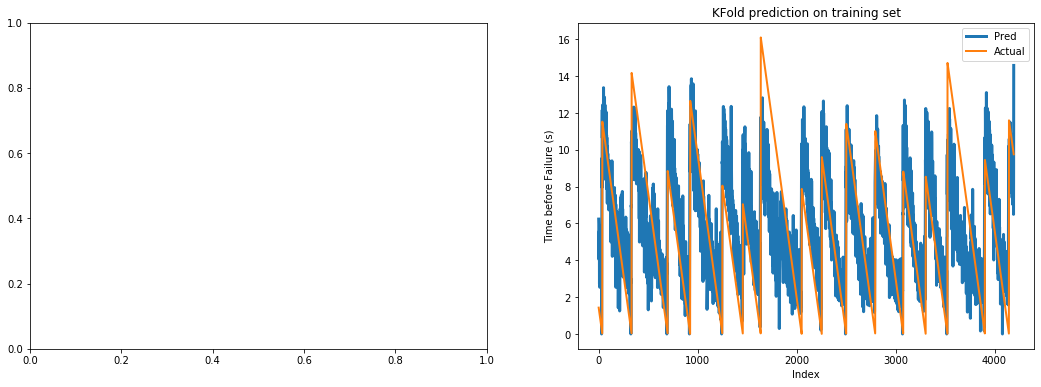

In [25]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation1(X[X.columns[0:]], y, X[X.columns[0:]], 
                                                                 nn,  'nn')

svm classifier
KFold 1: val_score = 2.10
KFold 2: val_score = 1.92
KFold 3: val_score = 2.08
KFold 4: val_score = 1.97
KFold 5: val_score = 2.06
-----------------------------------------------------------
Complete K-Fold and Cross Validation for svm
Validation MeanAbsoluteError: Mean = 2.027 Std = 0.070
CPU times: user 36.7 s, sys: 1.04 s, total: 37.8 s
Wall time: 31.6 s


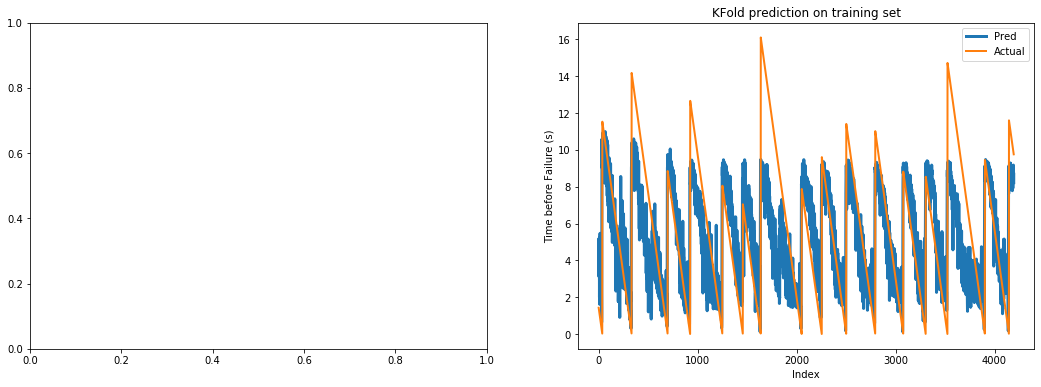

In [23]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation1(X[X.columns[0:]], y, X[X.columns[0:]], 
                                                                 svm_dimreduct,  'svm')

svm classifier
KFold 1: val_score = 2.09
KFold 2: val_score = 2.00
KFold 3: val_score = 2.11
KFold 4: val_score = 2.06
KFold 5: val_score = 2.07
-----------------------------------------------------------
Complete K-Fold and Cross Validation for svm
Validation MeanAbsoluteError: Mean = 2.065 Std = 0.038
CPU times: user 40.7 s, sys: 1.13 s, total: 41.8 s
Wall time: 35.1 s


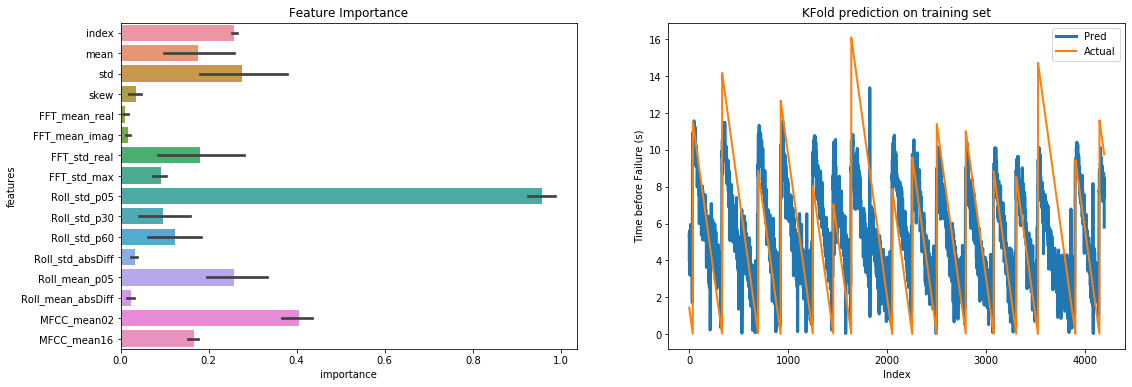

In [22]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation(X[X.columns[0:]], y, X[X.columns[0:]], 
                                                                 svm_regression,  'svm')